# Support Vector Machine Predictive Model for EDTA QC Evaluation: Part 3 – Model Application and Threshold Analysis

This notebook documents application of the final Support Vector Machine (SVM) classifier to EDTA QC data. The trained model is applied to UNKNOWNS-69, while DEV-165, TEST1-23, and TEST2-R23 are used for reference, visualization, and consistency checks. Decision scores are converted into classification outcomes using predefined operating thresholds, and model behaviour is examined using PCA-based visualization and threshold adjustment.

Contents:
- **Module Imports**

- **Optimization of the Decision Boundary and Prediction on Unseen Data**
    - Importing joblib libraries and safe threshold
    - Importing data and processing them
    - Decision scores
    - Predictions with default threshold = 0
    - PCA transformation
    - Visualization of the decision boundary
    - Key hyperparameters
    - Analyzing threshold ranges without changing FNR and FPR
    - Determining FNR and threshold ranges for reliable predictions
    - Selecting the decision threshold based on FNR
    - Built-in data and final outcome from EDTA_QC testing


----
----

#### Module Imports

In [50]:
import os
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from pathlib import Path
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
import warnings

In [ ]:
# Setup paths relative to project root
cwd = Path().cwd()
ROOT = cwd
while not (ROOT / "README.md").exists():
    ROOT = ROOT.parent
  
DATA_DIR   = ROOT / "data"
MODELS_DIR = ROOT / "models"
NB_OUTPUT   = ROOT / "notebooks" / "outputs_from_notebooks"

# Dataset paths (consistent with NB1 and NB2)
TRAIN_PATH = DATA_DIR / "train_165_data.csv"
TEST1_PATH    = DATA_DIR / "test1_data.csv"
TEST2_PATH    = DATA_DIR / "test2_data.csv"
UNKNOWN_PATH    = DATA_DIR / "unknown_only.csv"
THRESHOLD_PATH = MODELS_DIR / "safe_threshold.json"
EXCEL_PATH = NB_OUTPUT / "unknown_FNR_comparison.xlsx"

# Final model version used in NB1 and NB2
MODEL_PATH = MODELS_DIR / "final_pipeline_v1_2025-12-09.joblib" # for manual changing
PCA2_PATH = MODELS_DIR / "pca2.joblib" # for manual changing

In [52]:
print("ROOT:", ROOT)
print("TRAIN_PATH  exists:", TRAIN_PATH .exists())
print("TEST1_PATH exists:", TEST1_PATH.exists())
print("TEST2_PATH exists:", TEST2_PATH.exists())
print("UNKNOWN_PATH exists:", UNKNOWN_PATH.exists())
print("MODEL_PATH exists:", MODEL_PATH.exists())

ROOT: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce
TRAIN_PATH  exists: True
TEST1_PATH exists: True
TEST2_PATH exists: True
UNKNOWN_PATH exists: True
MODEL_PATH exists: True


----
----

#### **Optimization of the Decision Boundary and Prediction on Unseen Data**


#### Task 1: Importing joblib libraries and safe threshold

In [53]:
reloaded_pipeline = joblib.load(MODEL_PATH)

scaler = reloaded_pipeline.named_steps['scaler']
model  = reloaded_pipeline.named_steps['model']

In [54]:
with THRESHOLD_PATH.open("r", encoding="utf-8") as f:
    SAFE_THRESHOLD = json.load(f)["SAFE_THRESHOLD"]

print("Loaded SAFE_THRESHOLD:", SAFE_THRESHOLD)
print("From file:", THRESHOLD_PATH.resolve())

Loaded SAFE_THRESHOLD: -0.6750643265606378
From file: C:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\models\safe_threshold.json


In [55]:
PCA_PATH = MODELS_DIR / "pca2.joblib"
pca2 = joblib.load(PCA_PATH)

print("Loaded PCA from:", PCA_PATH)

Loaded PCA from: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\models\pca2.joblib


----

#### Task 2: Importing data and processing them

In [56]:
feature_cols = scaler.feature_names_in_

In [57]:
# Load datasets
train_165_df  = pd.read_csv(TRAIN_PATH, index_col=0)
test1_df  = pd.read_csv(TEST1_PATH, index_col=0)
test2_df  = pd.read_csv(TEST2_PATH, index_col=0)
unknown_df = pd.read_csv(UNKNOWN_PATH, index_col=0)

# Split into X and y (strictly using feature_cols!)
X_train = train_165_df[feature_cols]
y_train = train_165_df["groups"].astype(int)

X_test1 = test1_df[feature_cols]
y_test1 = test1_df["groups"].astype(int)

X_test2 = test2_df[feature_cols]
y_test2 = test2_df["groups"].astype(int)

X_unknown = unknown_df[feature_cols]

In [58]:
print(X_train.head)

<bound method NDFrame.head of                        BTG3      CD69     CXCR1     CXCR2    FCGR3A       JUN  \
sample                                                                          
1 EDTA val T0      5.480000  6.920000 -1.510000 -0.850000 -3.650000  3.150000   
1 EDTA val T24     2.840000  3.260000  0.730000  2.020000 -1.450000 -2.150000   
1 EDTA val T48     2.306667  2.186667  2.896667  4.296667  0.866667 -3.573333   
10 EDTA val T0     4.506667  5.486667 -2.143333 -0.913333 -3.443333  1.566667   
10 EDTA val T24    3.060000  2.230000  0.500000  1.790000 -1.380000 -2.340000   
...                     ...       ...       ...       ...       ...       ...   
8834 EDTA val T24  2.130000  0.840000  0.940000  1.780000 -1.920000 -3.320000   
8834 EDTA val T48  1.086667  0.266667  3.256667  4.826667  0.676667 -3.713333   
9 EDTA val T0      5.250000  6.490000 -1.520000 -0.750000 -3.360000  2.260000   
9 EDTA val T24     2.116667  2.286667  0.476667  1.986667 -1.013333 -2.363333  

----

#### Task 3: Decision scores

In [ ]:
# Decision scores (distance to boundary)
scores_train   = reloaded_pipeline.decision_function(X_train)
scores_test1   = reloaded_pipeline.decision_function(X_test1)
scores_test2   = reloaded_pipeline.decision_function(X_test2)
scores_unknown = reloaded_pipeline.decision_function(X_unknown)

In [60]:
print(scores_train[:10])
print(y_train[:10])

[ 2.28861684 -0.97414114 -1.18908948  1.39608948 -1.03410406 -1.25551518
  1.519609   -1.11341133 -1.21089635  1.41435597]
sample
1 EDTA val T0      1
1 EDTA val T24     0
1 EDTA val T48     0
10 EDTA val T0     1
10 EDTA val T24    0
10 EDTA val T48    0
11 EDTA val T0     1
11 EDTA val T24    0
11 EDTA val T48    0
12 EDTA val T0     1
Name: groups, dtype: int64


In [ ]:
print("Score shapes:",
      scores_train.shape,
      scores_test1.shape,
      scores_test2.shape,
      scores_unknown.shape)

Score shapes: (165,) (23,) (23,) (69,)


----

#### Task 4: Predictions with default threshold = 0

In [62]:
# Generating initial predictions with default threshold
y_pred_unknown_default   = (scores_unknown > 0).astype(int)
y_pred_train_default   = (scores_train > 0).astype(int)
y_pred_test2_default = (scores_test2  > 0).astype(int)
y_pred_test1_default  = (scores_test1  > 0).astype(int)

----

#### Task 5: PCA transformation

In [ ]:

# Transform TRAIN / TEST / UNKNOWN into PCA2 space
X_train_pca   = pca2.transform(scaler.transform(X_train))
X_test1_pca   = pca2.transform(scaler.transform(X_test1))
X_test2_pca   = pca2.transform(scaler.transform(X_test2))
X_unknown_pca = pca2.transform(scaler.transform(X_unknown))

print("Shapes:", X_train_pca.shape, X_test2_pca.shape, X_unknown_pca.shape)

Shapes: (165, 2) (23, 2) (69, 2)


----

#### Task 6: Visualization of the decision boundary

In [64]:
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names*",
    category=UserWarning,
    module="sklearn.utils.validation",
)

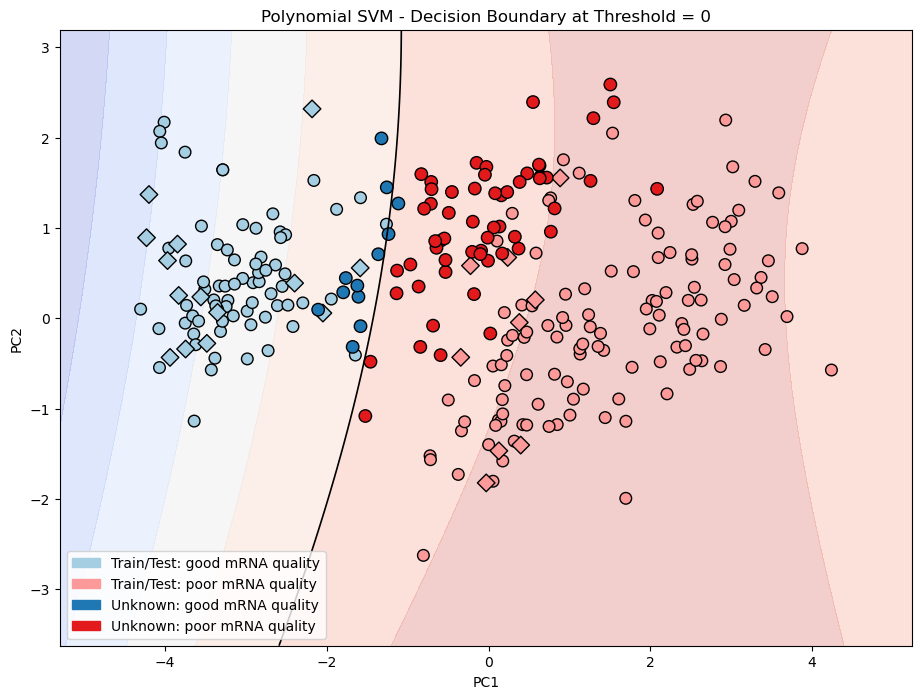

In [ ]:

# Decision Boundary Plot (Correct PCA)

# Limits of PCA space
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

# Prepare grid for decision surface (transform PCA → original space)
grid_pca2 = np.c_[xx.ravel(), yy.ravel()]
grid_scaled   = pca2.inverse_transform(grid_pca2)
grid_unscaled = scaler.inverse_transform(grid_scaled)

Z_scores = reloaded_pipeline.decision_function(grid_unscaled).reshape(xx.shape)

# Colors (consistent with NB2)
COLOR_GOOD  = "#a6cee3"
COLOR_POOR  = "#fb9a99"
COLOR_UNK_G = "#1f78b4"
COLOR_UNK_P = "#e31a1c"

plt.figure(figsize=(11, 8))
plt.title("Polynomial SVM - Decision Boundary at Threshold = 0")

# Background shading
plt.contourf(xx, yy, Z_scores, cmap="coolwarm_r", alpha=0.25)

# Decision boundary at score = 0
plt.contour(xx, yy, Z_scores,
            levels=[0],
            colors="black",
            linewidths=1.2,
            linestyles="solid")

# Scatter points
# TRAIN
plt.scatter(
    X_train_pca[:, 0], X_train_pca[:, 1],
    c=np.where(y_train == 1, COLOR_GOOD, COLOR_POOR),
    marker="o", edgecolors="k", s=70, label="Train"
)

# TEST1
plt.scatter(
    X_test1_pca[:, 0], X_test1_pca[:, 1],
    c=np.where(y_test1 == 1, COLOR_GOOD, COLOR_POOR),
    marker="o", edgecolors="k", s=70, label="Test1"
)

# TEST2
plt.scatter(
    X_test2_pca[:, 0], X_test2_pca[:, 1],
    c=np.where(y_test2 == 1, COLOR_GOOD, COLOR_POOR),
    marker="D", edgecolors="k", s=80, label="Test2"
)

# UNKNOWN samples
plt.scatter(
    X_unknown_pca[:, 0], X_unknown_pca[:, 1],
    c=np.where(y_pred_unknown_default == 1, COLOR_UNK_G, COLOR_UNK_P),
    marker="o", edgecolors="k", s=80, label="Unknown"
)


# Legend
patch_train_good = mpatches.Patch(color=COLOR_GOOD, label="Train/Test: good mRNA quality")
patch_train_poor = mpatches.Patch(color=COLOR_POOR, label="Train/Test: poor mRNA quality")

patch_unknown_good = mpatches.Patch(color=COLOR_UNK_G, label="Unknown: good mRNA quality")
patch_unknown_poor = mpatches.Patch(color=COLOR_UNK_P, label="Unknown: poor mRNA quality")

plt.legend(
    handles=[patch_train_good, patch_train_poor, patch_unknown_good, patch_unknown_poor],
    loc="lower left"
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

----

#### Task 7: Key hyperparameters

In [ ]:
# Key hyperparameters
print("\n=== Key hyperparameters ===")
print(f"Kernel: {model.kernel}")
print(f"Degree: {model.degree}")
print(f"C:      {model.C}")
print(f"Gamma:  {model.gamma}")
print(f"Coef0:  {model.coef0}")
print(f"Total support vectors: {model.support_vectors_.shape[0]}")

# Threshold-dependent evaluation (default threshold = 0)
print("\n=== Threshold-dependent parameters (threshold = 0) ===")

pos_default = np.sum(y_pred_unknown_default  == 1)
neg_default = np.sum(y_pred_unknown_default  == 0)

print(f"Number of unknown samples classified as OK (1):  {pos_default}")
print(f"Number of unknown samples classified as altered (0): {neg_default}")


=== Key hyperparameters ===
Kernel: poly
Degree: 2
C:      0.1
Gamma:  scale
Coef0:  0.5
Total support vectors: 29

=== Threshold-dependent parameters (threshold = 0) ===
Number of unknown samples classified as OK (1):  12
Number of unknown samples classified as altered (0): 57


----

#### Task 8: Analyzing threshold ranges without changing FNR and FPR

In [ ]:
# Test data score range
max_neg_score_test2 = scores_test2[y_test2 == 0].max()
min_pos_score_test2 = scores_test2[y_test2 == 1].min()

# Threshold range without altering test predictions, FNR, or FPR
print(f"↔️ Threshold range preserving test predictions, FNR, and FPR "
      f"({max_neg_score_test2:.2f}, {min_pos_score_test2:.2f}) ")

↔️ Threshold range preserving test predictions, FNR, and FPR (-0.68, 0.19) 


In [68]:
print(f"Safe threshold: {SAFE_THRESHOLD}")

Safe threshold: -0.6750643265606378


----

#### Task 9: Determining FNR and threshold ranges for reliable predictions

In [69]:
fnr_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [70]:
for fnr in range(0, 11):
    value = np.percentile(scores_test2[y_test2 == 0], 100 - fnr)
    print(f"FNR {fnr}% → threshold {value}")

FNR 0% → threshold -0.6750643265606378
FNR 1% → threshold -0.679843198729745
FNR 2% → threshold -0.6846220708988522
FNR 3% → threshold -0.6894009430679594
FNR 4% → threshold -0.6941798152370666
FNR 5% → threshold -0.6989586874061738
FNR 6% → threshold -0.7037375595752811
FNR 7% → threshold -0.7085164317443882
FNR 8% → threshold -0.7132953039134955
FNR 9% → threshold -0.7180741760826026
FNR 10% → threshold -0.7228530482517099



FNR: 0%
Adjusted threshold for 0% FNR: -0.68


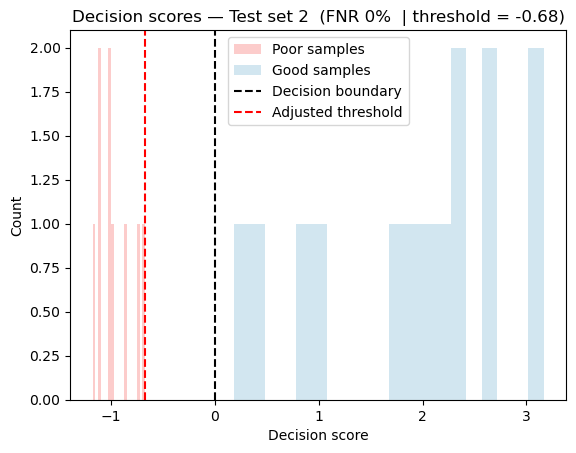

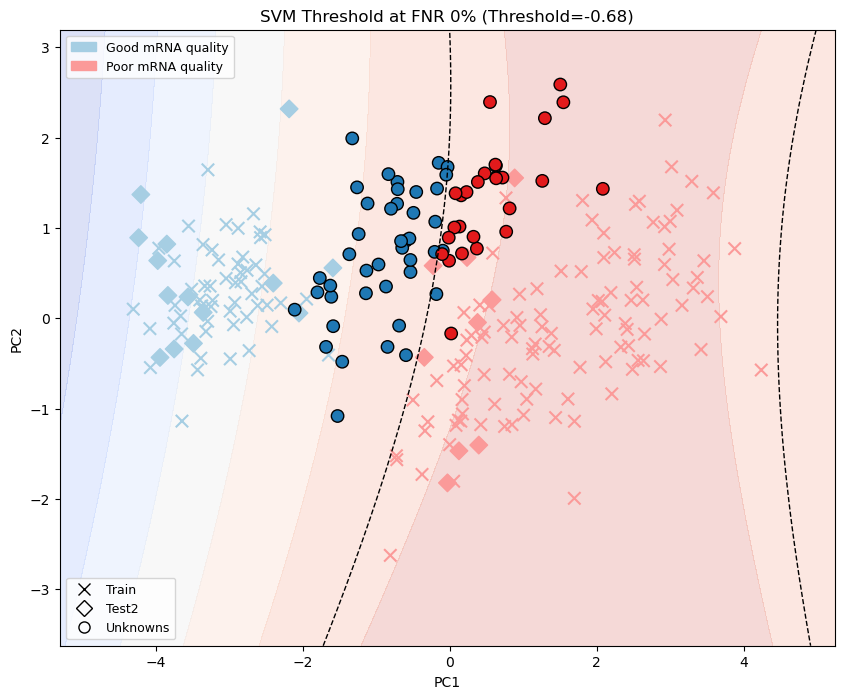

----------------------------------------

[Unknown Data]
# samples classified as OK (1): 42
# samples classified as poor or with altered gene expression (0): 27
# samples with changed classification compared to the threshold 0: 30
Changed samples:
1/1, 1/3, 100, 103, 111/2, 113, 136, 143/2, 185/2, 197/1, 197/3, 212/1, 212/3, 232/1, 239/1, 249/3, 260/1, 65/3, 75, 80, 85, 88, 99, CRC 106/2, CRC 178/2, CRC 180/1, CRC 180/3, CRC 2/1, CRC 83, CRC 95
✅ Unknown data exported to: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\notebooks\outputs_from_notebooks\unknown_predictions_FNR0.csv
----------------------------------------

[Original Train Data - Change Control]
No classification changes compared to original settings.
----------------------------------------

[Test 2 Data]
# samples classified as OK (1): 14
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA T0 7, EDTA T6 1, EDTA T

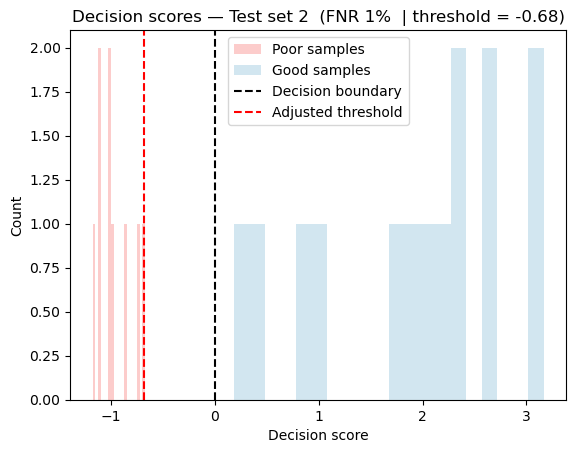

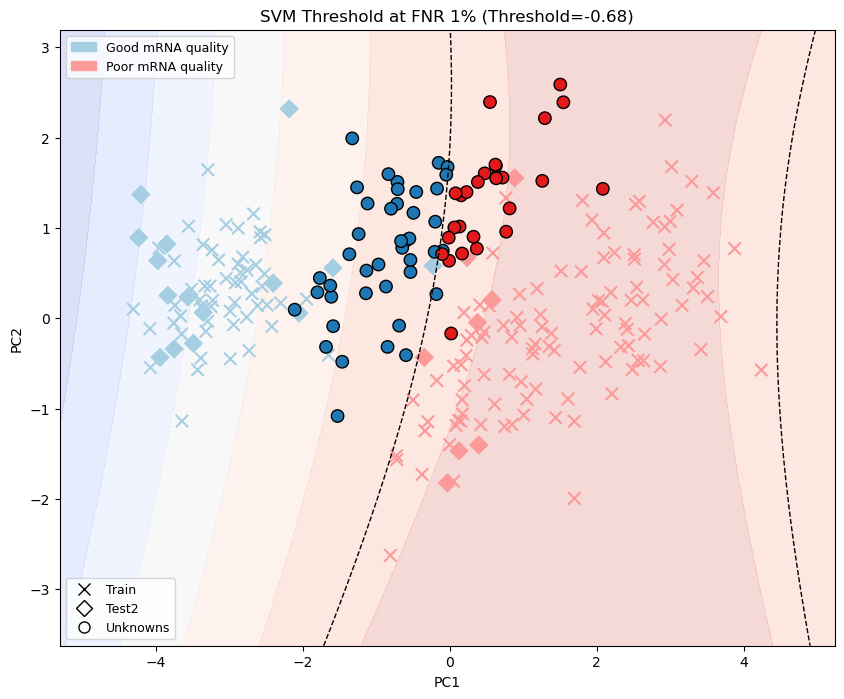

----------------------------------------

[Unknown Data]
# samples classified as OK (1): 42
# samples classified as poor or with altered gene expression (0): 27
# samples with changed classification compared to the threshold 0: 30
Changed samples:
1/1, 1/3, 100, 103, 111/2, 113, 136, 143/2, 185/2, 197/1, 197/3, 212/1, 212/3, 232/1, 239/1, 249/3, 260/1, 65/3, 75, 80, 85, 88, 99, CRC 106/2, CRC 178/2, CRC 180/1, CRC 180/3, CRC 2/1, CRC 83, CRC 95
✅ Unknown data exported to: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\notebooks\outputs_from_notebooks\unknown_predictions_FNR1.csv
----------------------------------------

[Original Train Data - Change Control]
No classification changes compared to original settings.
----------------------------------------

[Test 2 Data]
# samples classified as OK (1): 15
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA T0 7, EDTA T24 3, EDTA 

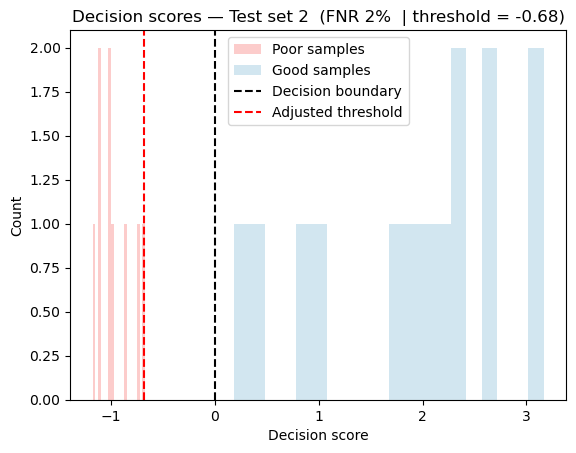

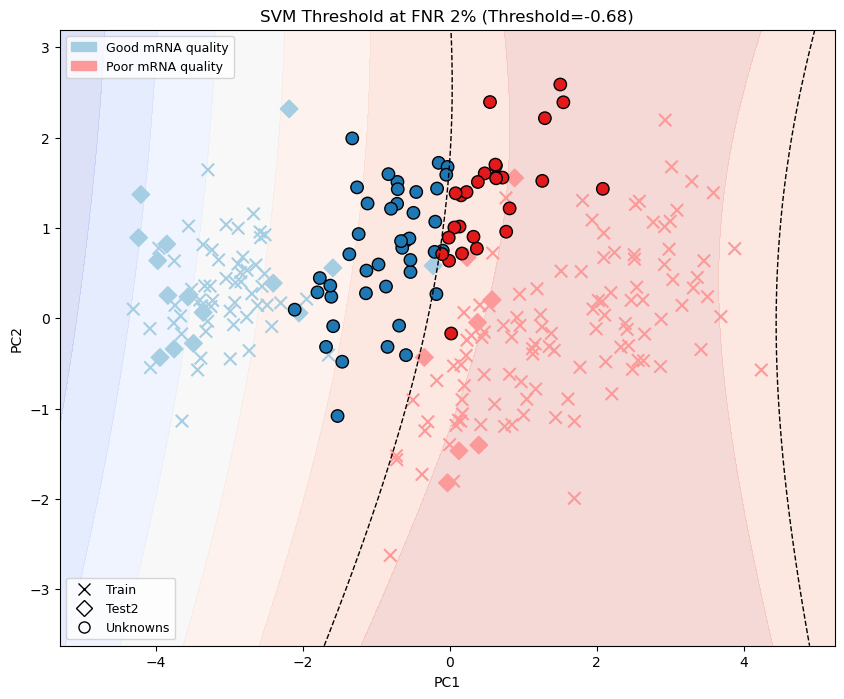

----------------------------------------

[Unknown Data]
# samples classified as OK (1): 42
# samples classified as poor or with altered gene expression (0): 27
# samples with changed classification compared to the threshold 0: 30
Changed samples:
1/1, 1/3, 100, 103, 111/2, 113, 136, 143/2, 185/2, 197/1, 197/3, 212/1, 212/3, 232/1, 239/1, 249/3, 260/1, 65/3, 75, 80, 85, 88, 99, CRC 106/2, CRC 178/2, CRC 180/1, CRC 180/3, CRC 2/1, CRC 83, CRC 95
✅ Unknown data exported to: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\notebooks\outputs_from_notebooks\unknown_predictions_FNR2.csv
----------------------------------------

[Original Train Data - Change Control]
No classification changes compared to original settings.
----------------------------------------

[Test 2 Data]
# samples classified as OK (1): 15
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA T0 7, EDTA T24 3, EDTA 

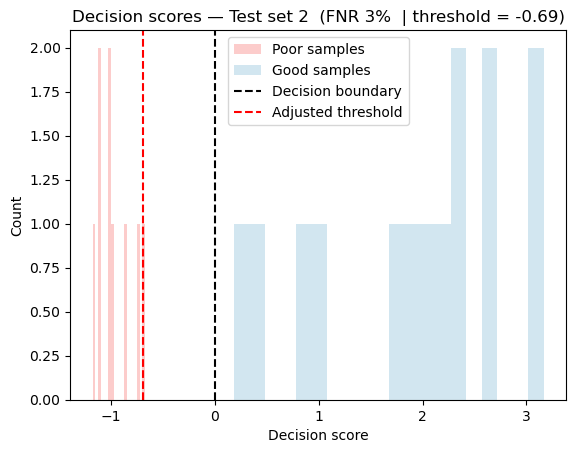

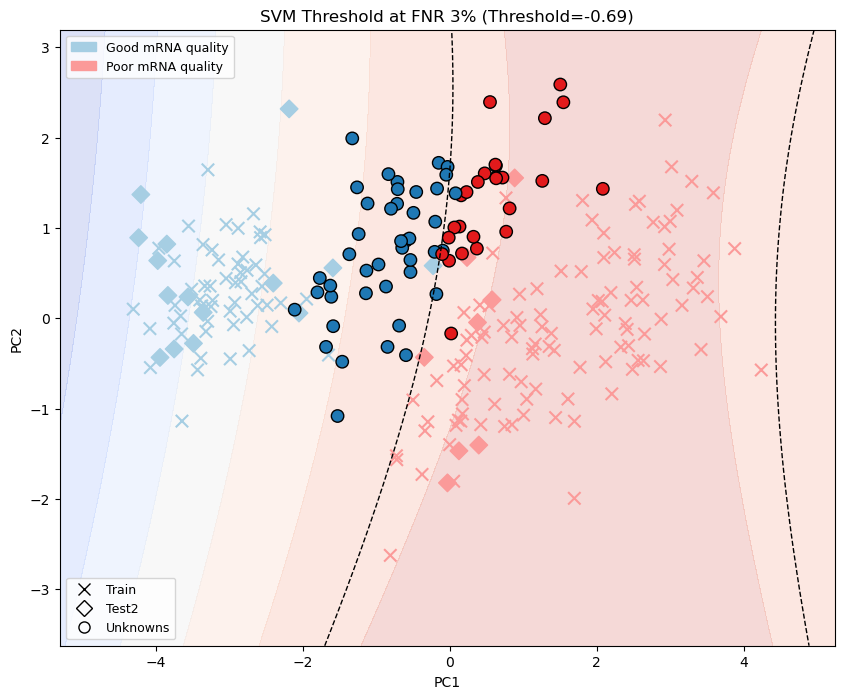

----------------------------------------

[Unknown Data]
# samples classified as OK (1): 43
# samples classified as poor or with altered gene expression (0): 26
# samples with changed classification compared to the threshold 0: 31
Changed samples:
1/1, 1/3, 100, 103, 111/2, 113, 136, 143/2, 185/2, 197/1, 197/3, 212/1, 212/2, 212/3, 232/1, 239/1, 249/3, 260/1, 65/3, 75, 80, 85, 88, 99, CRC 106/2, CRC 178/2, CRC 180/1, CRC 180/3, CRC 2/1, CRC 83, CRC 95
✅ Unknown data exported to: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\notebooks\outputs_from_notebooks\unknown_predictions_FNR3.csv
----------------------------------------

[Original Train Data - Change Control]
No classification changes compared to original settings.
----------------------------------------

[Test 2 Data]
# samples classified as OK (1): 15
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA T0 7, EDTA T24 3

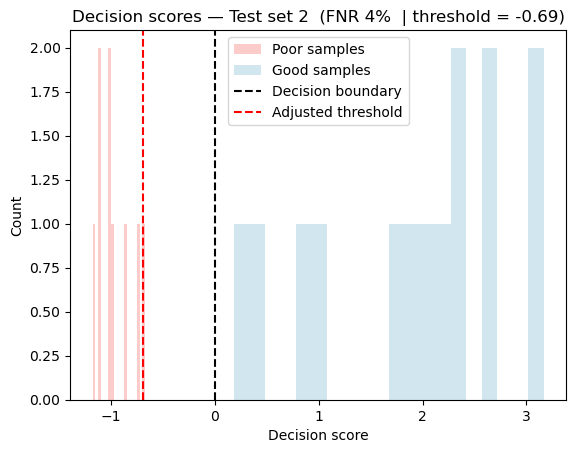

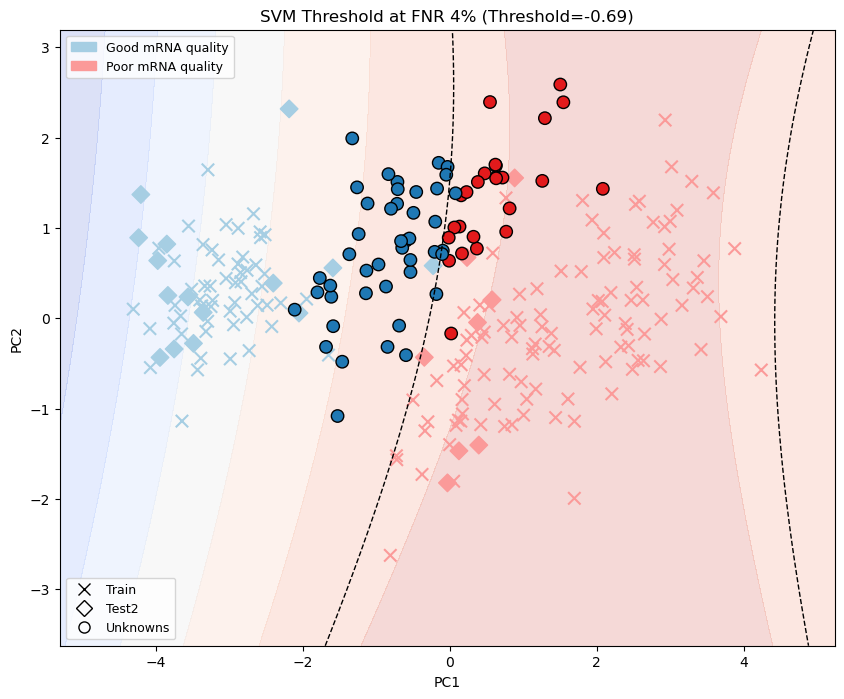

----------------------------------------

[Unknown Data]
# samples classified as OK (1): 44
# samples classified as poor or with altered gene expression (0): 25
# samples with changed classification compared to the threshold 0: 32
Changed samples:
1/1, 1/3, 100, 103, 111/2, 113, 136, 143/2, 185/2, 197/1, 197/3, 212/1, 212/2, 212/3, 232/1, 239/1, 249/3, 260/1, 65/3, 75, 80, 85, 88, 99, CRC 106/2, CRC 178/2, CRC 180/1, CRC 180/3, CRC 2/1, CRC 219/2, CRC 83, CRC 95
✅ Unknown data exported to: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\notebooks\outputs_from_notebooks\unknown_predictions_FNR4.csv
----------------------------------------

[Original Train Data - Change Control]
No classification changes compared to original settings.
----------------------------------------

[Test 2 Data]
# samples classified as OK (1): 15
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA T0 7,

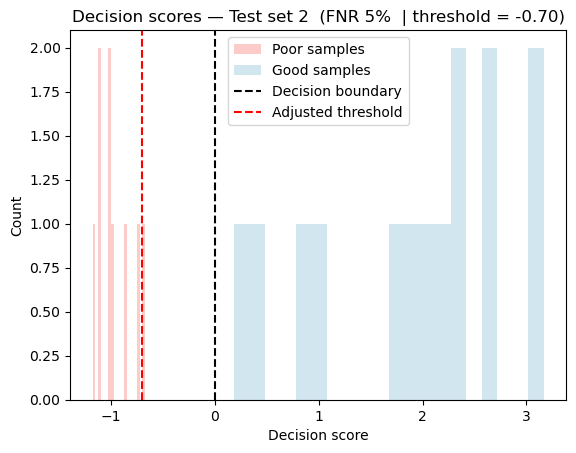

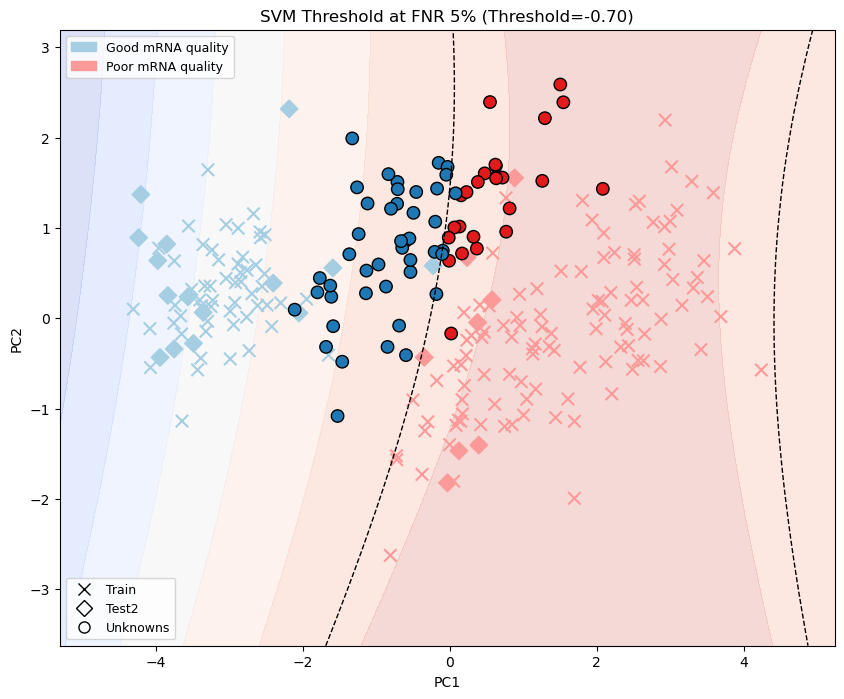

----------------------------------------

[Unknown Data]
# samples classified as OK (1): 44
# samples classified as poor or with altered gene expression (0): 25
# samples with changed classification compared to the threshold 0: 32
Changed samples:
1/1, 1/3, 100, 103, 111/2, 113, 136, 143/2, 185/2, 197/1, 197/3, 212/1, 212/2, 212/3, 232/1, 239/1, 249/3, 260/1, 65/3, 75, 80, 85, 88, 99, CRC 106/2, CRC 178/2, CRC 180/1, CRC 180/3, CRC 2/1, CRC 219/2, CRC 83, CRC 95
✅ Unknown data exported to: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\notebooks\outputs_from_notebooks\unknown_predictions_FNR5.csv
----------------------------------------

[Original Train Data - Change Control]
No classification changes compared to original settings.
----------------------------------------

[Test 2 Data]
# samples classified as OK (1): 15
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA T0 7,

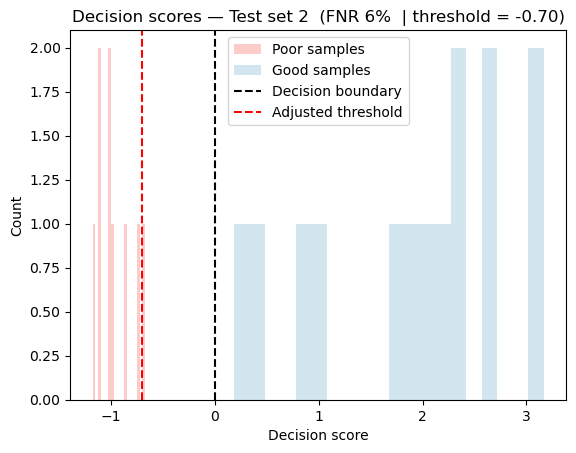

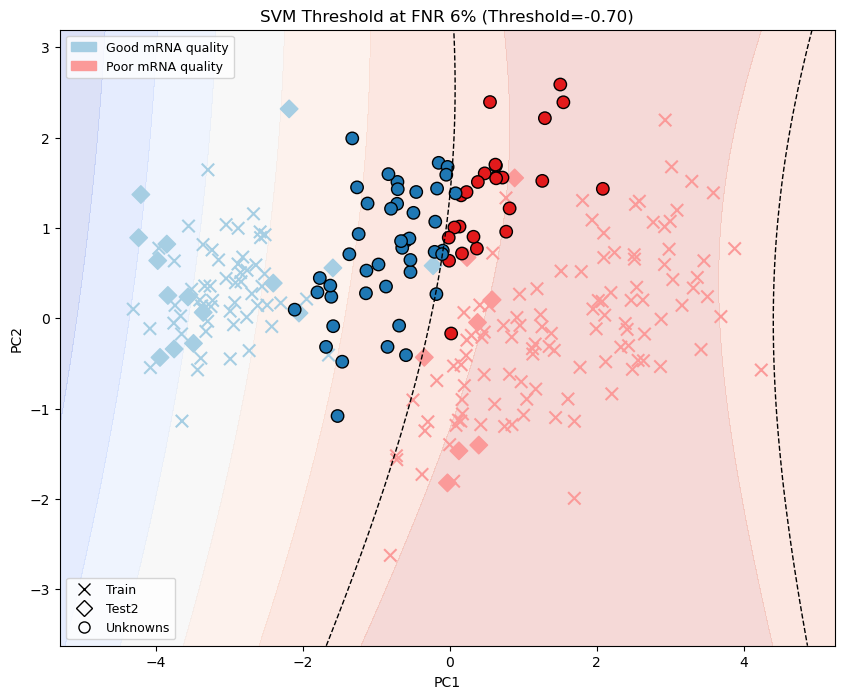

----------------------------------------

[Unknown Data]
# samples classified as OK (1): 44
# samples classified as poor or with altered gene expression (0): 25
# samples with changed classification compared to the threshold 0: 32
Changed samples:
1/1, 1/3, 100, 103, 111/2, 113, 136, 143/2, 185/2, 197/1, 197/3, 212/1, 212/2, 212/3, 232/1, 239/1, 249/3, 260/1, 65/3, 75, 80, 85, 88, 99, CRC 106/2, CRC 178/2, CRC 180/1, CRC 180/3, CRC 2/1, CRC 219/2, CRC 83, CRC 95
✅ Unknown data exported to: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\notebooks\outputs_from_notebooks\unknown_predictions_FNR6.csv
----------------------------------------

[Original Train Data - Change Control]
No classification changes compared to original settings.
----------------------------------------

[Test 2 Data]
# samples classified as OK (1): 15
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA T0 7,

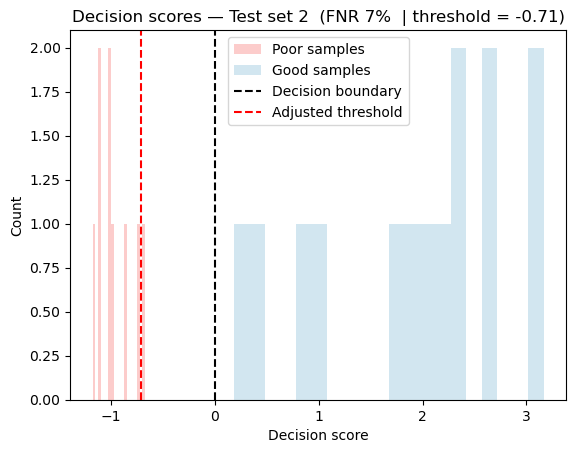

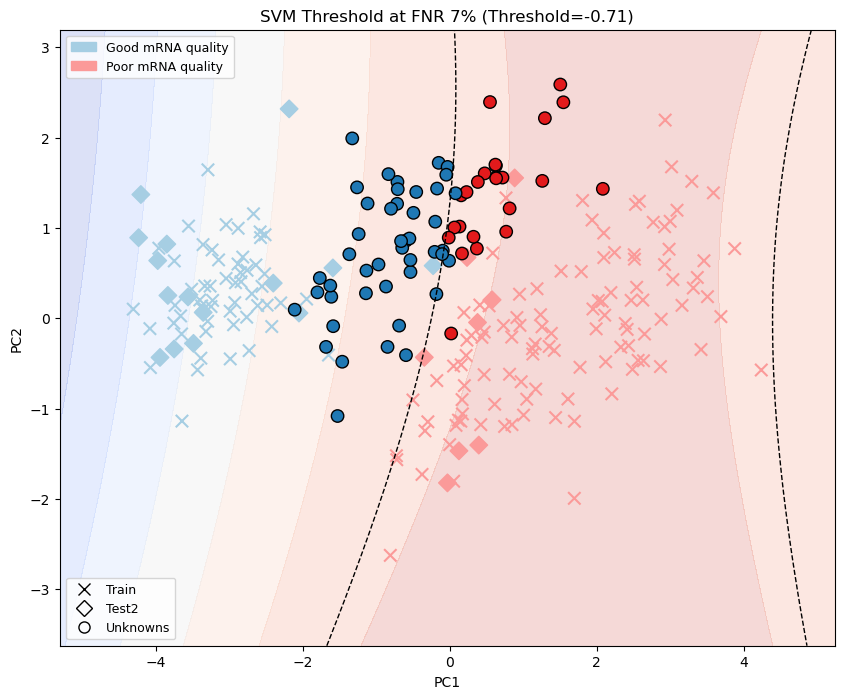

----------------------------------------

[Unknown Data]
# samples classified as OK (1): 45
# samples classified as poor or with altered gene expression (0): 24
# samples with changed classification compared to the threshold 0: 33
Changed samples:
1/1, 1/3, 100, 103, 111/2, 113, 136, 143/2, 185/2, 197/1, 197/3, 212/1, 212/2, 212/3, 232/1, 239/1, 249/3, 260/1, 65/3, 75, 80, 82, 85, 88, 99, CRC 106/2, CRC 178/2, CRC 180/1, CRC 180/3, CRC 2/1, CRC 219/2, CRC 83, CRC 95
✅ Unknown data exported to: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\notebooks\outputs_from_notebooks\unknown_predictions_FNR7.csv
----------------------------------------

[Original Train Data - Change Control]
No classification changes compared to original settings.
----------------------------------------

[Test 2 Data]
# samples classified as OK (1): 15
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA T

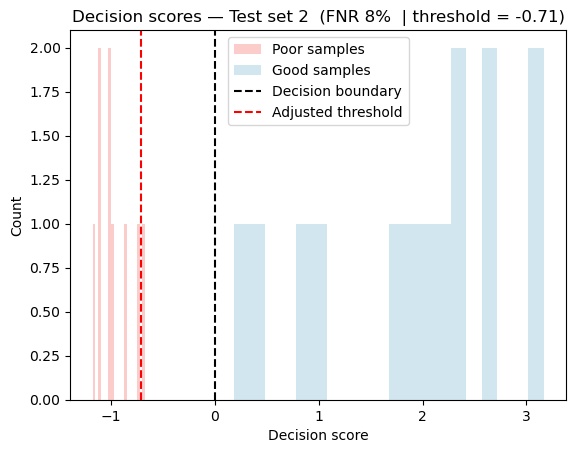

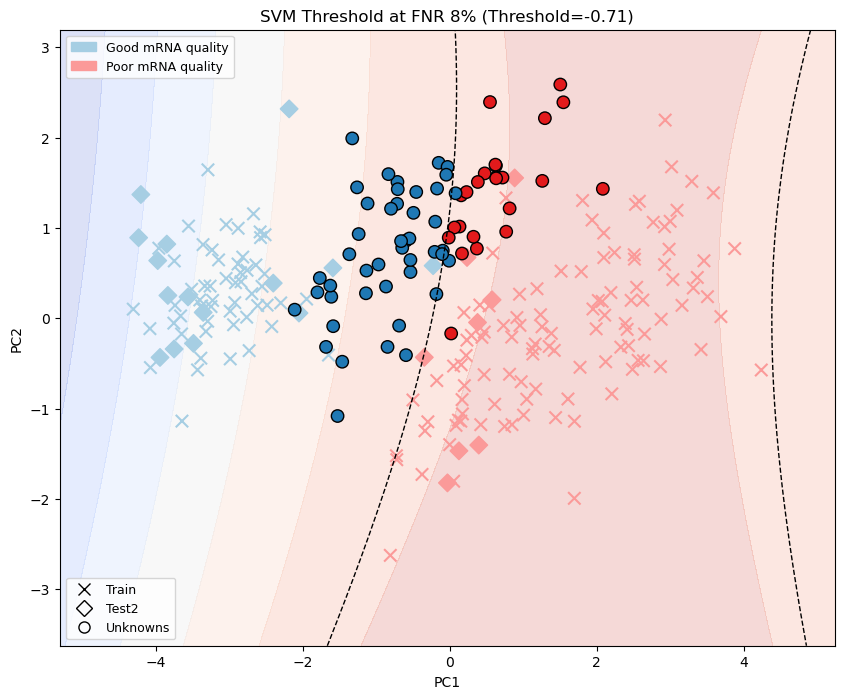

----------------------------------------

[Unknown Data]
# samples classified as OK (1): 45
# samples classified as poor or with altered gene expression (0): 24
# samples with changed classification compared to the threshold 0: 33
Changed samples:
1/1, 1/3, 100, 103, 111/2, 113, 136, 143/2, 185/2, 197/1, 197/3, 212/1, 212/2, 212/3, 232/1, 239/1, 249/3, 260/1, 65/3, 75, 80, 82, 85, 88, 99, CRC 106/2, CRC 178/2, CRC 180/1, CRC 180/3, CRC 2/1, CRC 219/2, CRC 83, CRC 95
✅ Unknown data exported to: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\notebooks\outputs_from_notebooks\unknown_predictions_FNR8.csv
----------------------------------------

[Original Train Data - Change Control]
No classification changes compared to original settings.
----------------------------------------

[Test 2 Data]
# samples classified as OK (1): 15
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA T

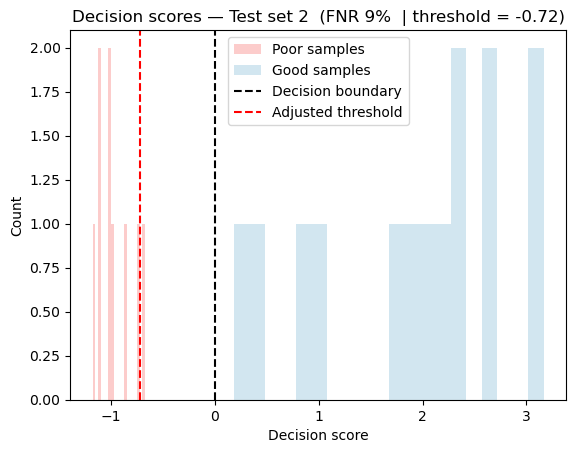

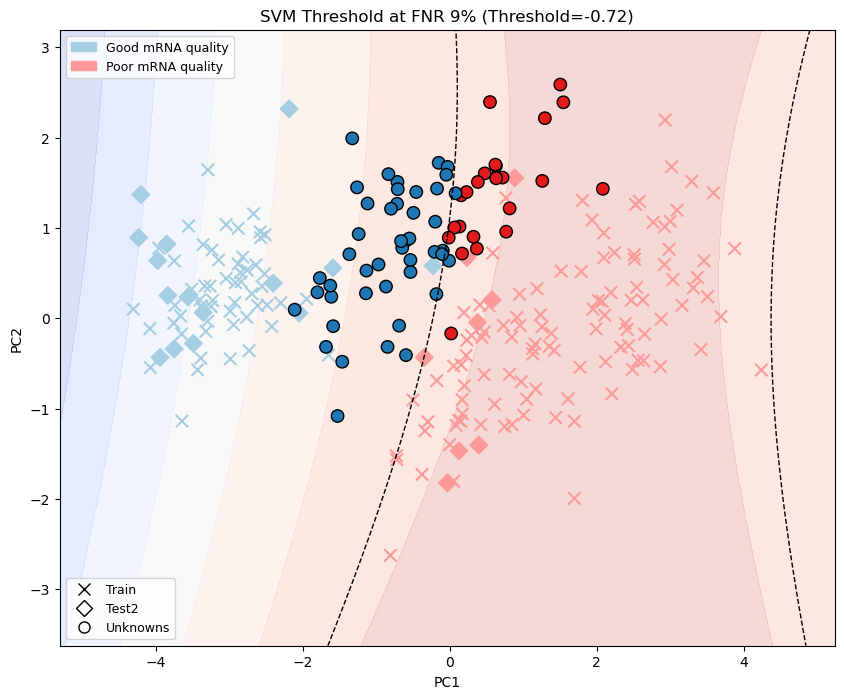

----------------------------------------

[Unknown Data]
# samples classified as OK (1): 45
# samples classified as poor or with altered gene expression (0): 24
# samples with changed classification compared to the threshold 0: 33
Changed samples:
1/1, 1/3, 100, 103, 111/2, 113, 136, 143/2, 185/2, 197/1, 197/3, 212/1, 212/2, 212/3, 232/1, 239/1, 249/3, 260/1, 65/3, 75, 80, 82, 85, 88, 99, CRC 106/2, CRC 178/2, CRC 180/1, CRC 180/3, CRC 2/1, CRC 219/2, CRC 83, CRC 95
✅ Unknown data exported to: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\notebooks\outputs_from_notebooks\unknown_predictions_FNR9.csv
----------------------------------------

[Original Train Data - Change Control]
No classification changes compared to original settings.
----------------------------------------

[Test 2 Data]
# samples classified as OK (1): 15
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA T

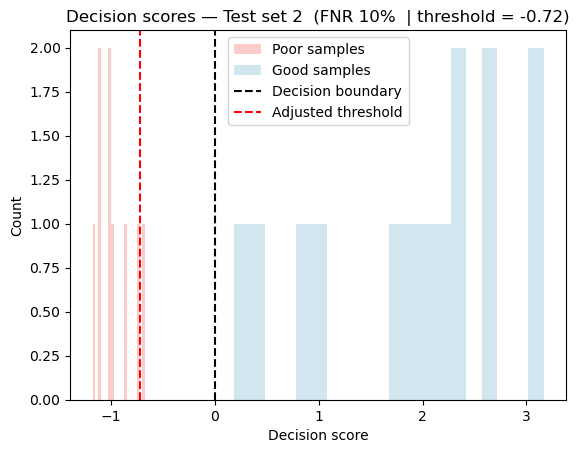

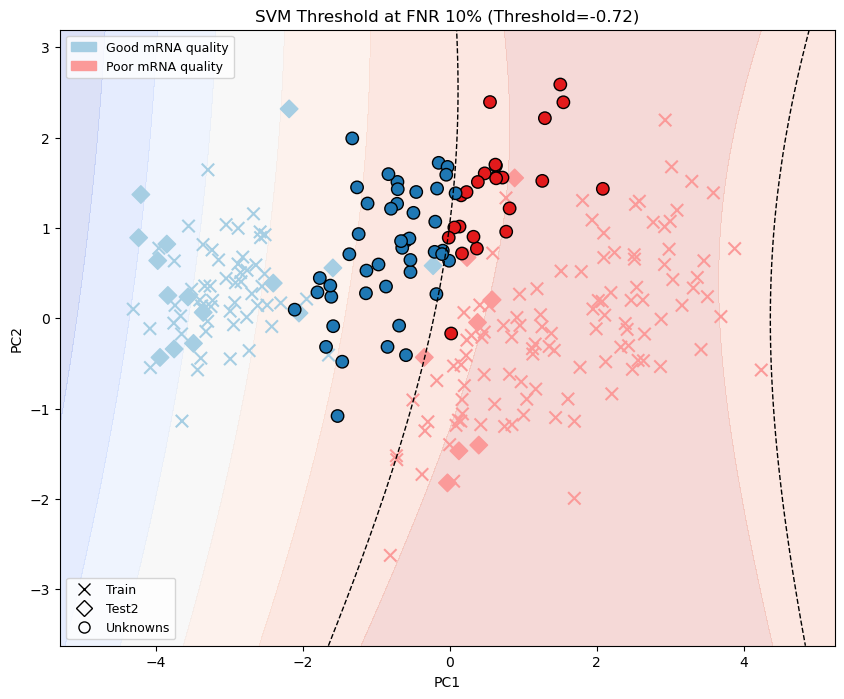

----------------------------------------

[Unknown Data]
# samples classified as OK (1): 45
# samples classified as poor or with altered gene expression (0): 24
# samples with changed classification compared to the threshold 0: 33
Changed samples:
1/1, 1/3, 100, 103, 111/2, 113, 136, 143/2, 185/2, 197/1, 197/3, 212/1, 212/2, 212/3, 232/1, 239/1, 249/3, 260/1, 65/3, 75, 80, 82, 85, 88, 99, CRC 106/2, CRC 178/2, CRC 180/1, CRC 180/3, CRC 2/1, CRC 219/2, CRC 83, CRC 95
✅ Unknown data exported to: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\notebooks\outputs_from_notebooks\unknown_predictions_FNR10.csv
----------------------------------------

[Original Train Data - Change Control]
No classification changes compared to original settings.
----------------------------------------

[Test 2 Data]
# samples classified as OK (1): 15
EDTA 8759-0, EDTA 8760-0, EDTA 8761-0, EDTA 8762-0, EDTA 8764-0, EDTA T0 1, EDTA T0 2, EDTA T0 3, EDTA T0 6, EDTA 

In [ ]:
for fnr in fnr_list:
    print(f"\n{'='*50}\nFNR: {fnr}%")

    test_samples = test2_df.index.to_numpy()
    train_samples = train_165_df.index.to_numpy()
    unknown_samples = unknown_df.index.to_numpy()

    # Calculating threshold from test 2 scores for poor-quality samples
    bad_scores_test2 = scores_test2[y_test2 == 0]

     # Higher FNR → threshold moves left (accepting more poor samples)
    threshold_dynamic2 = np.percentile(bad_scores_test2, 100 - fnr)
    print(f"Adjusted threshold for {fnr}% FNR: {threshold_dynamic2:.2f}")

    # Updating predictions based on dynamic threshold
    y_train_adj = (scores_train > threshold_dynamic2).astype(int)
    y_test1_adj = (scores_test1 > threshold_dynamic2).astype(int)
    y_test2_adj = (scores_test2 > threshold_dynamic2).astype(int)
    y_unk_adj = (scores_unknown > threshold_dynamic2).astype(int)

    # Histogram of decision scores (Test2)
    plt.hist(scores_test2[y_test2 == 0], bins=20, alpha=0.5, label="Poor samples", color="#fb9a99")
    plt.hist(scores_test2[y_test2 == 1], bins=20, alpha=0.5, label="Good samples", color="#a6cee3")
    plt.axvline(x=0, color='k', linestyle='--', label='Decision boundary')
    plt.axvline(x=threshold_dynamic2, color='red', linestyle='--', label='Adjusted threshold')
    plt.legend()
    plt.title(f"Decision scores — Test set 2  (FNR {fnr}%  | threshold = {threshold_dynamic2:.2f})")
    plt.xlabel("Decision score")
    plt.ylabel("Count")
    plt.show()

    # Decision boundary plot in PCA2 space (visual only)
    plt.figure(figsize=(10, 8))
    plt.title(f"SVM Threshold at FNR {fnr}% (Threshold={threshold_dynamic2:.2f})")

    # PCA grid (2D → inverse PCA → inverse scaler → decision_function)
    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
    
    grid_pca2 = np.c_[xx.ravel(), yy.ravel()]
    grid_scaled = pca2.inverse_transform(grid_pca2)
    grid_raw = scaler.inverse_transform(grid_scaled)
    Z_scores = reloaded_pipeline.decision_function(grid_raw).reshape(xx.shape)

    #  Define custom colormaps for plotting
    cmap_train = mcolors.ListedColormap(['#fb9a99', '#a6cee3'])  # Light colors for train data
    cmap_unknown =  mcolors.ListedColormap(['#e31a1c', '#1f78b4'])

    plt.contourf(xx, yy, Z_scores, alpha=0.2, cmap=plt.cm.coolwarm_r) # Decision boundary
    plt.contour(xx, yy, Z_scores, levels=[threshold_dynamic2], colors='black', linewidths=1) #levels are responsible for the threshold

    # Scatter plot: training data
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
        c=y_train_adj, cmap=cmap_train, marker='x', s=80, label='Train')

     # Scatter plot: training data
    plt.scatter(X_test2_pca[:, 0], X_test2_pca[:, 1],
        c=y_test2_adj, cmap=cmap_train, marker='D', s=80, label='Test2')
   
    # Scatter plot: unknown data
    plt.scatter(X_unknown_pca[:, 0], X_unknown_pca[:, 1],
        c=y_unk_adj, cmap=cmap_unknown, edgecolors='k', s=80, label='Unknowns')

    plt.xlabel('PC1')
    plt.ylabel('PC2')

    # Legend 1
    ax = plt.gca()
    train_proxy   = plt.Line2D([0], [0], marker='x', color='none',
                           markerfacecolor='black', markersize=8, label='Train')

    test2_proxy   = plt.Line2D([0], [0], marker='D', color='none',
                           markerfacecolor='none', markeredgecolor='black', markersize=8, label='Test2')

    unknown_proxy = plt.Line2D([0], [0], marker='o', color='none',
                           markerfacecolor='none', markeredgecolor='black', markersize=8, label='Unknowns')
    
    legend1 = ax.legend(handles=[train_proxy, test2_proxy, unknown_proxy],
                    loc='lower left', fontsize=9)
    ax.add_artist(legend1) 


    # Legend 2
    patch0_train = mpatches.Patch(color='#a6cee3', label='Good mRNA quality')
    patch1_train = mpatches.Patch(color='#fb9a99', label='Poor mRNA quality')

    plt.legend(handles=[patch0_train, patch1_train], loc='upper left', fontsize=9)
    plt.show()

    # UNKNOWN data (we are interested in)

    # Convert to array for safe and uniform indexing
    unk_arr   = np.asarray(unknown_samples)   # unknown sample IDs
 
    # Indices of classifications
    good_unk_idx = np.where(y_unk_adj == 1)[0]
    bad_unk_idx = np.where(y_unk_adj == 0)[0]
    changed_unk_idx = np.where(y_unk_adj != y_pred_unknown_default )[0]

    # Retrieve sample IDs for changed samples
    changed_unk_samples = unk_arr[changed_unk_idx].tolist()

    print("-"*40)
    print("\n[Unknown Data]")
    print(f"# samples classified as OK (1): {len(good_unk_idx)}")
    print(f"# samples classified as poor or with altered gene expression (0): {len(bad_unk_idx)}")
    print(f"# samples with changed classification compared to the threshold 0: {len(changed_unk_idx)}")

    if len(changed_unk_samples) > 0:
        print("Changed samples:")
        print(", ".join(map(str, changed_unk_samples)))
    else:
        print("No classification changes compared to threshold 0.")

    # Save predictions to CSV in the notebook’s output folder
    output_df = pd.DataFrame({
        'sample': unk_arr,
        f'predicted_class_FNR{fnr}': y_unk_adj
    })
    
    filename = NB_OUTPUT / f"unknown_predictions_FNR{fnr}.csv"
    output_df.to_csv(filename, index=False)
    print(f"✅ Unknown data exported to: {filename}")

    # TRAIN data (change control)

    print("-"*40)
    print("\n[Original Train Data - Change Control]")

    # Convert to array for safe and uniform indexing
    train_arr = np.asarray(train_samples)

    # Identify samples whose classification changed relative to threshold 0
    changed_train_idx = np.where(y_train_adj != y_pred_train_default )[0]
    changed_train_samples = train_arr[changed_train_idx].tolist()

    if len(changed_train_idx) > 0:
        print(f"⚠️ {len(changed_train_idx)} training samples changed classification compared to original settings!")
        print("Changed samples:")
        print(", ".join(map(str, changed_train_samples)))
    else:
        print("No classification changes compared to original settings.")

     # TEST data

    print("-"*40)
    print("\n[Test 2 Data]")

    # Convert to array for safe and uniform indexing
    test_arr = np.asarray(test_samples)

    # Identify good / poor / changed samples
    good_test_idx = np.where(y_test2_adj == 1)[0]
    bad_test_idx  = np.where(y_test2_adj == 0)[0]
    changed_test_idx = np.where(y_test2_adj != y_pred_test2_default )[0]

    # Retrieve sample names safely
    good_test_samples    = test_arr[good_test_idx].tolist()
    bad_test_samples     = test_arr[bad_test_idx].tolist()
    changed_test_samples = test_arr[changed_test_idx].tolist()

    print(f"# samples classified as OK (1): {len(good_test_idx)}")
    print(", ".join(map(str, good_test_samples)) if good_test_samples else "None samples")

    print(f"\n# samples classified as altered (0): {len(bad_test_idx)}")
    print(", ".join(map(str, bad_test_samples)) if bad_test_samples else "None samples")

    print(f"\n# samples with changed classification compared to the threshold 0: {len(changed_test_idx)}")
    if changed_test_samples:
        print(", ".join(map(str, changed_test_samples)))
    else:
        print("No samples changed classification compared to original threshold.")

In [ ]:
print("Count poor in test2:", np.sum(y_test2 == 0))
print("Count good in test2:", np.sum(y_test2 == 1))

Count poor in test2: 9
Count good in test2: 14


----

#### Task 10: Selecting the decision threshold based on FNR

Threshold adjustment was explored by selecting operating thresholds corresponding to predefined false-negative rates (FNR) for EDTA-affected samples (class 0; treated as the positive class), i.e. the fraction of EDTA-affected reference samples classified as PASS at a given threshold. The safe threshold (FNR = 0%) represents the most conservative setting, in which no EDTA-affected reference samples are classified as PASS.

Relaxed thresholds corresponding to higher FNR values were evaluated to illustrate the effect of threshold adjustment on classification outcomes. In this notebook, an FNR of 10% was used as a predefined example operating point for UNKNOWNS-69. This choice was used to illustrate threshold-dependent behaviour and did not involve retraining or recalibration of the model.


----

#### Task 11: Built-in data and final outcome from EDTA_QC testing

In [ ]:

# Define thresholds

# Safe threshold (FNR = 0 %)
thr_safe = SAFE_THRESHOLD

# Compute FNR 5% and FNR 10% thresholds
bad_scores_test2 = scores_test2[y_test2 == 0]

thr_fnr5  = np.percentile(bad_scores_test2, 100 - 5)
thr_fnr10 = np.percentile(bad_scores_test2, 100 - 10)

print("Thresholds:")
print(f"SAFE (FNR=0%):   {thr_safe:.4f}")
print(f"FNR = 5%:         {thr_fnr5:.4f}")
print(f"FNR = 10%:        {thr_fnr10:.4f}")

# Helper function
def classify(scores, threshold):
    return (scores > threshold).astype(int)

unk_names = unknown_df.index.to_numpy()

# Predictions
y_safe   = classify(scores_unknown, thr_safe)
y_fnr5   = classify(scores_unknown, thr_fnr5)
y_fnr10  = classify(scores_unknown, thr_fnr10)

# Build table
rows = []

for i, sample in enumerate(unk_names):

    rows.append({
        "Sample": sample,
        "Class @ SAFE (FNR0)":  y_safe[i],
        "Class @ FNR5":         y_fnr5[i],
        "Class @ FNR10":        y_fnr10[i],
    })

df_compare = pd.DataFrame(rows)

# Show table
df_compare


Thresholds:
SAFE (FNR=0%):   -0.6751
FNR = 5%:         -0.6990
FNR = 10%:        -0.7229


,Sample,Class @ SAFE (FNR0),Class @ FNR5,Class @ FNR10
0,1/1,1,1,1
1,1/2,0,0,0
2,1/3,1,1,1
3,100,1,1,1
4,103,1,1,1
...,...,...,...,...
64,CRC 5/3,0,0,0
65,CRC 65/1,1,1,1
66,CRC 78,0,0,0
67,CRC 83,1,1,1


In [74]:

df_compare.to_excel(EXCEL_PATH, index=False)

print("Excel saved to:", EXCEL_PATH)


Excel saved to: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\notebooks\outputs_from_notebooks\unknown_FNR_comparison.xlsx


C:\Users\UserPhD\AppData\Local\Temp\ipykernel_39008\1224281587.py:1: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  df_compare.to_excel(EXCEL_PATH, index=False)


To illustrate application of the EDTA QC tool, a subset of samples from a previously published dataset was analyzed (Slyskova et al., 2015), as not all original samples were available. The analyzed subset included samples from healthy volunteers, pre-operative colorectal carcinoma patients, early post-operative patients, and patients in remission, profiled using a cancer-marker panel. For downstream analysis, samples collected six months after surgery in remission were grouped with healthy controls, while pre-operative and early post-operative samples were grouped with diseased samples.


![Filtering](FIGURE5.png)


In this Figure, the PCA plot is shown after EDTA QC filtering. A predefined false-negative rate of 10% was applied. Under this setting, 24 out of 69 analyzed samples were flagged and excluded as affected by EDTA-related expression changes.



----
----

Go to application via terminal: streamlit run src/app.py